In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as ply
import plotly.tools as tls
from plotly.offline import iplot
import cufflinks as cf
ply.offline.init_notebook_mode(connected=True)
cf.go_offline()

import plotly.figure_factory as pff

In [2]:
train_df = pd.read_excel(r'data/Data_Train.xlsx')
train_df.head()


Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
train_df['Duration'].value_counts()

2h 50m     550
1h 30m     386
2h 55m     337
2h 45m     337
2h 35m     329
          ... 
35h 20m      1
41h 20m      1
33h 20m      1
47h          1
36h 25m      1
Name: Duration, Length: 368, dtype: int64

In [6]:
train_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
train_df.dropna(inplace=True)

In [8]:
train_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [9]:
train_df.shape

(10682, 11)

## EDA

From description we can see that Date_of_Journey is a object data type,\ Therefore, we have to convert this datatype into timestamp so as to use this column properly for prediction

For this we require pandas to_datetime to convert object data type to datetime dtype.

#### .dt.day method will extract only day of that date
#### .dt.month method will extract only month of that date

In [10]:
train_df['Journey_day'] = pd.to_datetime(train_df.Date_of_Journey, format='%d/%m/%Y').dt.day
train_df['Journey_month'] = pd.to_datetime(train_df.Date_of_Journey, format='%d/%m/%Y').dt.month

# Since we have converted Date_of_Journey column into integers, Now we can drop as it is of no use.
train_df.drop(['Date_of_Journey'], axis=1, inplace=True)

In [11]:
# Similar to Date_of_Journey, extracting Dep_hour and Dep_minute from Dep_Time
train_df['Dep_hour'] = pd.to_datetime(train_df.Dep_Time).dt.hour
train_df['Dep_minute'] = pd.to_datetime(train_df.Dep_Time).dt.minute

train_df.drop(['Dep_Time'], axis=1, inplace=True)

In [12]:
# Similar to Date_of_Journey, extracting Dep_hour and Dep_minute from Dep_Time
train_df['Arrival_hour'] = pd.to_datetime(train_df.Arrival_Time).dt.hour
train_df['Arrival_minute'] = pd.to_datetime(train_df.Arrival_Time).dt.minute

train_df.drop(['Arrival_Time'], axis=1, inplace=True)

In [13]:
temp = ['2h 50m','19h']
for i in range(len(temp)):
    print(temp[i].split())
    print('Length : ',len(temp[i].split()))
    if len(temp[i].split()) != 2:
        if "h" in temp[i]:
            temp[i] = temp[i].strip() + " 0m"   # Adds 0 minute
            print('if part : ', temp[i])
        else:
            temp[i] = "0h " + temp[i]           # Adds 0 hour
            print("else part :", temp[i])

['2h', '50m']
Length :  2
['19h']
Length :  1
if part :  19h 0m


In [14]:
print(temp[0])


2h 50m


In [15]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time


# Assigning and converting Duration column into list
duration = list(train_df["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

In [16]:
# Adding duration_hours and duration_mins list to train_data dataframe

train_df["Duration_hours"] = duration_hours
train_df["Duration_mins"] = duration_mins

train_df.drop(['Duration'], axis=1, inplace=True)

## Handling Categorical Data

One can find many ways to handle categorical data. Some of them categorical data are,

#### **Nominal data** --> data are not in any order --> **OneHotEncoder** is used in this case
#### **Ordinal data** --> data are in order --> **LabelEncoder** is used in this case

In [17]:
train_df.head(2)

Airline    Source Destination                  Route Total_Stops  \
0     IndiGo  Banglore   New Delhi              BLR → DEL    non-stop   
1  Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR     2 stops   

  Additional_Info  Price  Journey_day  Journey_month  Dep_hour  Dep_minute  \
0         No info   3897           24              3        22          20   
1         No info   7662            1              5         5          50   

   Arrival_hour  Arrival_minute  Duration_hours  Duration_mins  
0             1              10               2             50  
1            13              15               7             25

In [18]:
train_df['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

### Troubled Indian airline Jet Airways has temporarily suspended all its domestic and international flights after failing to find fresh funding.

Replacing Jet Airways and Jet Airways Business with np.nan and doing fractional distribution of all the nan values to all the other airlines.

In [19]:
train_df['Airline'].replace('Jet Airways', np.nan, inplace=True)
train_df['Airline'].replace('Jet Airways Business', np.nan, inplace=True)

train_df['Airline'].isnull().sum()

3855

In [20]:
def FilterDataset(Feature):
    featuredata_list = train_df[Feature].unique().tolist()
    data_count = train_df[Feature].value_counts().sum()
    Null = train_df[Feature].isnull().sum()
    mask_mat = train_df[Feature].isna()
    Frac = 0
    for data in featuredata_list:
        if Null > 0:
            Frac = (len(train_df[train_df[Feature] == data])/data_count)
            data_count = data_count - len(train_df[train_df[Feature] == data])
            ind = train_df[Feature].loc[mask_mat].sample(frac=Frac, replace=True).index
            train_df.loc[ind, Feature] = data
            mask_mat = train_df[Feature].isna()
            Null = train_df[Feature].isnull().sum()
    else:print(Feature + " Sorted")

In [21]:
FilterDataset('Airline')

Airline Sorted


In [22]:
train_df['Airline'].isnull().sum()

23

In [23]:
train_df['Airline'].value_counts()

IndiGo                               3057
Air India                            2628
Multiple carriers                    1819
SpiceJet                             1290
Vistara                               802
Air Asia                              569
GoAir                                 347
Multiple carriers Premium economy      84
Trujet                                 35
Vistara Premium economy                28
Name: Airline, dtype: int64

In [24]:
FilterDataset('Airline')

Airline Sorted


In [25]:
train_df['Airline'].isnull().sum()

0

In [26]:
train_df['Airline'].value_counts()

IndiGo                               3064
Air India                            2633
Multiple carriers                    1821
SpiceJet                             1293
Vistara                               804
Air Asia                              571
GoAir                                 348
Multiple carriers Premium economy      84
Trujet                                 36
Vistara Premium economy                28
Name: Airline, dtype: int64

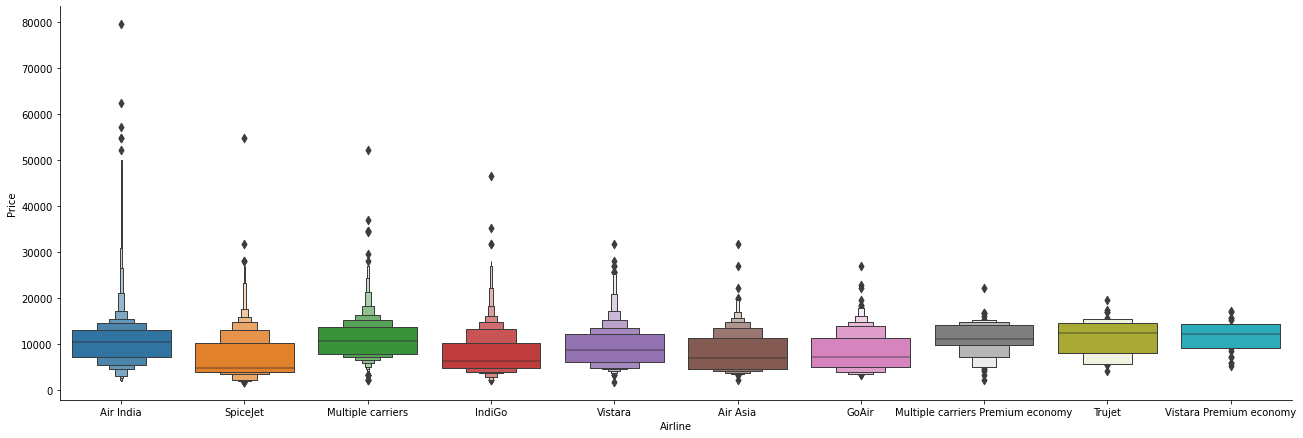

In [27]:
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = train_df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [28]:
import plotly_express as px
px.box(train_df.sort_values('Price', ascending=False), x = "Airline", y = 'Price', 
       color = 'Airline',
       color_discrete_sequence = px.colors.colorbrewer.Paired, 
       hover_name = 'Airline',points='outliers')

In [31]:
# As Airline is Nominal Categorical Data we will perform One-Hot Encoding
Airline = train_df[['Airline']]
Airline = pd.get_dummies(Airline, drop_first=True)
Airline.head(2)

Airline_Air India  Airline_GoAir  Airline_IndiGo  \
0                  0              0               1   
1                  1              0               0   

   Airline_Multiple carriers  Airline_Multiple carriers Premium economy  \
0                          0                                          0   
1                          0                                          0   

   Airline_SpiceJet  Airline_Trujet  Airline_Vistara  \
0                 0               0                0   
1                 0               0                0   

   Airline_Vistara Premium economy  
0                                0  
1                                0

In [32]:
train_df['Source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [33]:
# Source vs Price

import plotly_express as px
px.box(train_df.sort_values('Price', ascending=False), x = "Source", y = 'Price', 
       color = 'Source',
       color_discrete_sequence = px.colors.colorbrewer.Paired, 
       hover_name = 'Source',points='outliers')

In [34]:
# As Source is a Nominal CAtegorical Data , we will perform One-Hot Encoding gain similar to what we did for Airline Feature

Source = train_df[['Source']]
Source = pd.get_dummies(Source, drop_first=True)
Source.head(2)

Source_Chennai  Source_Delhi  Source_Kolkata  Source_Mumbai
0               0             0               0              0
1               0             0               1              0

In [35]:
train_df['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [36]:
# As Destination feature in Nominal Categorical Data , we will perform One-Hot Encoding similarly

Destination = train_df[['Destination']]
Destination = pd.get_dummies(Destination, drop_first=True)
Destination.head(2)

Destination_Cochin  Destination_Delhi  Destination_Hyderabad  \
0                   0                  0                      0   
1                   0                  0                      0   

   Destination_Kolkata  Destination_New Delhi  
0                    0                      1  
1                    0                      0

#### Routes and Total_Stops are actually performing the same tasks, So we can drop the Routes Feature.
#### Additional_Info feature contains almost 80% data as 'no_info', so we drop this feature column also.
#### In 'Airline', 'Source' and 'Destination', we have performed One-Hot Encoding, so drop these 3 columns also.

In [37]:
train_df.drop(['Route', 'Additional_Info'], axis=1, inplace=True)

In [38]:
train_df.head(2)

Airline    Source Destination Total_Stops  Price  Journey_day  \
0     IndiGo  Banglore   New Delhi    non-stop   3897           24   
1  Air India   Kolkata    Banglore     2 stops   7662            1   

   Journey_month  Dep_hour  Dep_minute  Arrival_hour  Arrival_minute  \
0              3        22          20             1              10   
1              5         5          50            13              15   

   Duration_hours  Duration_mins  
0               2             50  
1               7             25

In [39]:
train_df['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [40]:
# Here 'Total_Stops' is Ordinal Categorical Data, so we will perform Label-Encoding for this feature
train_df.replace({'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}, inplace=True)

In [41]:
train_df.head(2)

Airline    Source Destination  Total_Stops  Price  Journey_day  \
0     IndiGo  Banglore   New Delhi            0   3897           24   
1  Air India   Kolkata    Banglore            2   7662            1   

   Journey_month  Dep_hour  Dep_minute  Arrival_hour  Arrival_minute  \
0              3        22          20             1              10   
1              5         5          50            13              15   

   Duration_hours  Duration_mins  
0               2             50  
1               7             25

In [42]:
final_train_df = pd.concat([train_df, Airline, Source, Destination], axis=1)
final_train_df.drop(['Airline', 'Source', 'Destination'], axis=1, inplace=True, )
final_train_df.head()

Total_Stops  Price  Journey_day  Journey_month  Dep_hour  Dep_minute  \
0            0   3897           24              3        22          20   
1            2   7662            1              5         5          50   
2            2  13882            9              6         9          25   
3            1   6218           12              5        18           5   
4            1  13302            1              3        16          50   

   Arrival_hour  Arrival_minute  Duration_hours  Duration_mins  ...  \
0             1              10               2             50  ...   
1            13              15               7             25  ...   
2             4              25              19              0  ...   
3            23              30               5             25  ...   
4            21              35               4             45  ...   

   Airline_Vistara Premium economy  Source_Chennai  Source_Delhi  \
0                                0               0             0   
1                                0               0             0   
2                                0               0             1   
3                                0               0             0   
4                                0               0             0   

   Source_Kolkata  Source_Mumbai  Destination_Cochin  Destination_Delhi  \
0               0              0                   0                  0   
1               1              0                   0                  0   
2               0              0                   1                  0   
3               1              0                   0                  0   
4               0              0                   0                  0   

   Destination_Hyderabad  Destination_Kolkata  Destination_New Delhi  
0                      0                    0                      1  
1                      0                    0                      0  
2                      0                    0                      0  
3                      0                    0                      0  
4                      0                    0                      1  

[5 rows x 28 columns]

In [188]:
train_df['Airline'].unique()

array(['IndiGo', 'Air India', 'SpiceJet', 'Vistara',
       'Multiple carriers Premium economy', 'Multiple carriers', 'GoAir',
       'Air Asia', 'Trujet', 'Vistara Premium economy'], dtype=object)

# Test Set

In [43]:
test_df = pd.read_excel(r'data/Test_set.xlsx')
test_df.head(2)

Airline Date_of_Journey   Source Destination            Route Dep_Time  \
0  Jet Airways       6/06/2019    Delhi      Cochin  DEL → BOM → COK    17:30   
1       IndiGo      12/05/2019  Kolkata    Banglore  CCU → MAA → BLR    06:20   

   Arrival_Time Duration Total_Stops Additional_Info  
0  04:25 07 Jun  10h 55m      1 stop         No info  
1         10:20       4h      1 stop         No info

In [44]:
test_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

### Date_of_Journey

In [45]:
test_df['Journey_day'] = pd.to_datetime(test_df.Date_of_Journey, format='%d/%m/%Y' ).dt.day
test_df['Journey_month']=pd.to_datetime(test_df.Date_of_Journey, format='%d/%m/%Y').dt.month

test_df.drop(['Date_of_Journey'], axis=1, inplace=True)

### Dep_Time && Arrival_Time

In [46]:
test_df['Dep_hour']=pd.to_datetime(test_df.Dep_Time).dt.hour
test_df['Dep_min']=pd.to_datetime(test_df.Dep_Time).dt.minute

test_df.drop(['Dep_Time'], axis=1, inplace=True)

In [47]:
# Arrival_Time
test_df['Arrival_hour']=pd.to_datetime(test_df.Arrival_Time).dt.hour
test_df['Arrival_min']=pd.to_datetime(test_df.Arrival_Time).dt.minute

test_df.drop(['Arrival_Time'], axis=1, inplace=True)

### Duration

In [48]:
duration = list(test_df["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration

# Adding Duration column to test set
test_df["Duration_hours"] = duration_hours
test_df["Duration_mins"] = duration_mins
test_df.drop(["Duration"], axis = 1, inplace = True)

In [49]:
# Dropping 'Route' && 'Additional_Info'--> no use
test_df.drop(['Route' , 'Additional_Info'], axis=1, inplace=True)

In [50]:
test_df.head(1)

Airline Source Destination Total_Stops  Journey_day  Journey_month  \
0  Jet Airways  Delhi      Cochin      1 stop            6              6   

   Dep_hour  Dep_min  Arrival_hour  Arrival_min  Duration_hours  Duration_mins  
0        17       30             4           25              10             55

## Nominal Categorical Data: 'Airline' , 'Source' , 'Destination' --> One-Hot Encoding
## Ordninal Categorical Data: 'Total_Stops' --> Label Encoding

### Airline

In [51]:
test_df['Airline'].value_counts()

Jet Airways                          897
IndiGo                               511
Air India                            440
Multiple carriers                    347
SpiceJet                             208
Vistara                              129
Air Asia                              86
GoAir                                 46
Multiple carriers Premium economy      3
Jet Airways Business                   2
Vistara Premium economy                2
Name: Airline, dtype: int64

In [52]:
test_df.replace('Jet Airways', np.nan, inplace=True)
test_df.replace('Jet Airways Business', np.nan, inplace=True)

test_df['Airline'].isnull().sum()

899

In [53]:
def FilterDataset(Feature):
    featuredata_list = test_df[Feature].unique().tolist()
    data_count = test_df[Feature].value_counts().sum()
    Null = test_df[Feature].isnull().sum()
    mask_mat = test_df[Feature].isna()
    Frac = 0
    for data in featuredata_list:
        if Null > 0:
            Frac = (len(test_df[test_df[Feature] == data])/data_count)
            data_count = data_count - len(test_df[test_df[Feature] == data])
            ind = test_df[Feature].loc[mask_mat].sample(frac=Frac, replace=True).index
            test_df.loc[ind, Feature] = data
            mask_mat = test_df[Feature].isna()
            Null = test_df[Feature].isnull().sum()
    else:print(Feature + " Sorted")

In [54]:
FilterDataset('Airline')

Airline Sorted


In [55]:
test_df['Airline'].isnull().sum()

12

In [56]:
FilterDataset('Airline')

Airline Sorted


In [57]:
test_df['Airline'].isnull().sum()

0

In [58]:
test_df['Airline'].value_counts()

IndiGo                               742
Air India                            639
Multiple carriers                    511
SpiceJet                             320
Vistara                              201
Air Asia                             135
GoAir                                 95
Multiple carriers Premium economy     23
Vistara Premium economy                5
Name: Airline, dtype: int64

In [59]:
# One-Hot Encoding
Airline = test_df[['Airline']]
Airline = pd.get_dummies(Airline, drop_first=True)
Airline.head(1)

Airline_Air India  Airline_GoAir  Airline_IndiGo  \
0                  0              0               0   

   Airline_Multiple carriers  Airline_Multiple carriers Premium economy  \
0                          0                                          0   

   Airline_SpiceJet  Airline_Vistara  Airline_Vistara Premium economy  
0                 0                0                                0

### Source

In [60]:
test_df['Source'].value_counts()

Delhi       1145
Kolkata      710
Banglore     555
Mumbai       186
Chennai       75
Name: Source, dtype: int64

In [61]:
Source = test_df[['Source']]
Source = pd.get_dummies(Source, drop_first=True)
Source.head(1)

Source_Chennai  Source_Delhi  Source_Kolkata  Source_Mumbai
0               0             1               0              0

### Destination

In [62]:
test_df['Destination'].value_counts()

Cochin       1145
Banglore      710
Delhi         317
New Delhi     238
Hyderabad     186
Kolkata        75
Name: Destination, dtype: int64

In [63]:
Destination = test_df[['Destination']]
Destination = pd.get_dummies(Destination, drop_first=True)
Destination.head(1)

Destination_Cochin  Destination_Delhi  Destination_Hyderabad  \
0                   1                  0                      0   

   Destination_Kolkata  Destination_New Delhi  
0                    0                      0

### Total_Stops

In [64]:
# Label Encoding
test_df['Total_Stops'].value_counts()

1 stop      1431
non-stop     849
2 stops      379
3 stops       11
4 stops        1
Name: Total_Stops, dtype: int64

In [65]:
test_df.replace({'non-stop':0 , '1 stop':1 , '2 stops':2 , '3 stops':3 , '4 stops':4}, inplace=True)
test_df.head(3)

Airline   Source Destination  Total_Stops  Journey_day  Journey_month  \
0  Air Asia    Delhi      Cochin            1            6              6   
1    IndiGo  Kolkata    Banglore            1           12              5   
2  SpiceJet    Delhi      Cochin            1           21              5   

   Dep_hour  Dep_min  Arrival_hour  Arrival_min  Duration_hours  Duration_mins  
0        17       30             4           25              10             55  
1         6       20            10           20               4              0  
2        19       15            19            0              23             45

In [66]:
final_test_df = pd.concat([test_df, Airline, Source, Destination] , axis=1)
final_test_df.drop(['Airline' , 'Source' , 'Destination'] , axis=1 , inplace=True)
final_test_df.head()

Total_Stops  Journey_day  Journey_month  Dep_hour  Dep_min  Arrival_hour  \
0            1            6              6        17       30             4   
1            1           12              5         6       20            10   
2            1           21              5        19       15            19   
3            1           21              5         8        0            21   
4            0           24              6        23       55             2   

   Arrival_min  Duration_hours  Duration_mins  Airline_Air India  ...  \
0           25              10             55                  0  ...   
1           20               4              0                  0  ...   
2            0              23             45                  0  ...   
3            0              13              0                  0  ...   
4           45               2             50                  0  ...   

   Airline_Vistara Premium economy  Source_Chennai  Source_Delhi  \
0                                0               0             1   
1                                0               0             0   
2                                0               0             1   
3                                0               0             1   
4                                0               0             0   

   Source_Kolkata  Source_Mumbai  Destination_Cochin  Destination_Delhi  \
0               0              0                   1                  0   
1               1              0                   0                  0   
2               0              0                   1                  0   
3               0              0                   1                  0   
4               0              0                   0                  1   

   Destination_Hyderabad  Destination_Kolkata  Destination_New Delhi  
0                      0                    0                      0  
1                      0                    0                      0  
2                      0                    0                      0  
3                      0                    0                      0  
4                      0                    0                      0  

[5 rows x 26 columns]

In [67]:
final_test_df.columns

Index(['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour', 'Dep_min',
       'Arrival_hour', 'Arrival_min', 'Duration_hours', 'Duration_mins',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Vistara', 'Airline_Vistara Premium economy', 'Source_Chennai',
       'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi'],
      dtype='object')

# Feature Selection

Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

1. heatmap
2. feature_importance_**
3. SelectKBest**

In [68]:
final_train_df.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_minute', 'Arrival_hour', 'Arrival_minute', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [69]:
X = final_train_df.loc[:, ['Total_Stops', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_minute', 'Arrival_hour', 'Arrival_minute', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'] ]
X.head(2)                    

Total_Stops  Journey_day  Journey_month  Dep_hour  Dep_minute  \
0            0           24              3        22          20   
1            2            1              5         5          50   

   Arrival_hour  Arrival_minute  Duration_hours  Duration_mins  \
0             1              10               2             50   
1            13              15               7             25   

   Airline_Air India  ...  Airline_Vistara Premium economy  Source_Chennai  \
0                  0  ...                                0               0   
1                  1  ...                                0               0   

   Source_Delhi  Source_Kolkata  Source_Mumbai  Destination_Cochin  \
0             0               0              0                   0   
1             0               1              0                   0   

   Destination_Delhi  Destination_Hyderabad  Destination_Kolkata  \
0                  0                      0                    0   
1                  0                      0                    0   

   Destination_New Delhi  
0                      1  
1                      0  

[2 rows x 27 columns]

In [70]:
y = final_train_df.iloc[:,1]
y.head(2)

0    3897
1    7662
Name: Price, dtype: int64

#### Finds correlation between Independent and dependent attributes using HEATMAP-PLOTLY
#### Here train_df is used because there's no need of Nominal and Ordinal Categorical data.
#### Because Nominal & Ordinal categorical data ar never correlated

In [71]:
px.imshow(train_df.corr(), width=600, height=600, title='Heatmap',) 

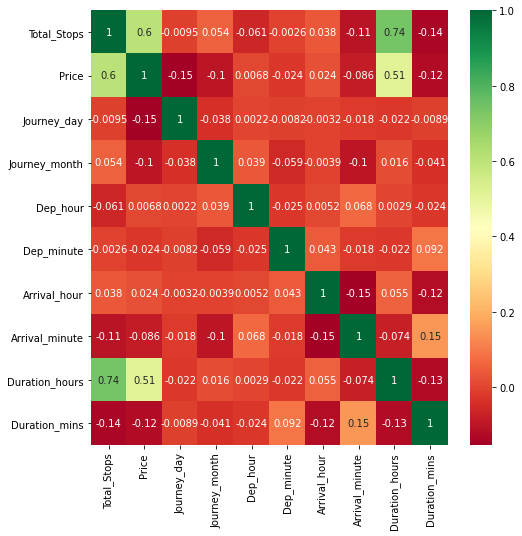

In [72]:
# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (8,8))
sns.heatmap(train_df.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [77]:
# Important features using Extra Trees Regressor
from sklearn.ensemble import ExtraTreesRegressor
feature_selection = ExtraTreesRegressor()
feature_selection.fit(X,y)

ExtraTreesRegressor()

In [79]:
print(feature_selection.feature_importances_)

[0.24959875 0.15793067 0.05014254 0.03989764 0.03962609 0.04604874
 0.03803559 0.18026077 0.03219635 0.02291822 0.00400285 0.01241517
 0.00985132 0.00123192 0.00809549 0.00057119 0.00566975 0.00052306
 0.00214066 0.00734212 0.007395   0.00383359 0.00852216 0.03342149
 0.00521059 0.00064184 0.03247644]


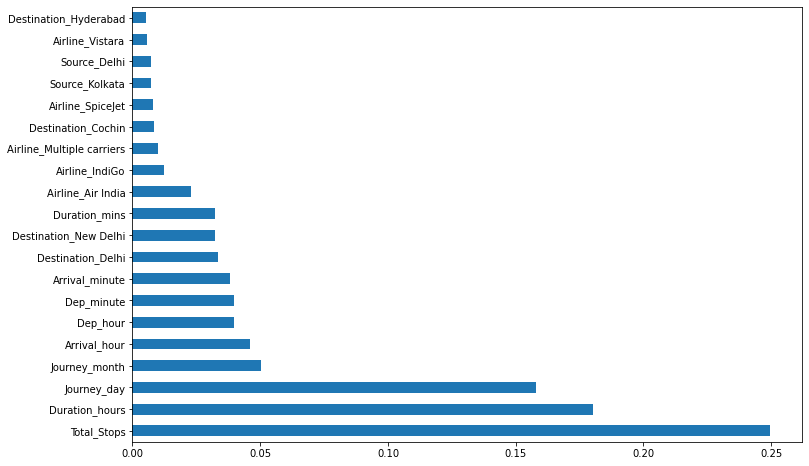

In [80]:

#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(feature_selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [174]:


fig = go.Figure(go.Bar(x=feat_importances.nlargest(20),
                       y=X.columns, marker_color=np.random.randn(2),
                       orientation='h', width=0.7,text=y,
                       textposition='auto') 
               )



fig.show()
# 'indianred', 'magenta', 'aqua', 'aquamarine', 'violet',
#                 'beige', 'bisque', 'black', 'blanchedalmond', 'blue',
#                 'blueviolet', 'brown', 'burlywood', 'cadetblue',
#                 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
#                 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan',
#                 'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
#                 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange'

## Fitting model using Random Forest

Split dataset into train and test set in order to prediction w.r.t X_test

If needed do scaling of data

Scaling is not done in Random forest

Import model

Fit the data

Predict w.r.t X_test

In regression check RSME Score

Plot graph

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [106]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8545, 27)
(2137, 27)
(8545,)
(2137,)


In [108]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train , y_train)

RandomForestRegressor()

In [109]:
y_pred = rf_reg.predict(X_test)

In [110]:
rf_reg.score(X_train, y_train)

0.9650156750266424

In [111]:
rf_reg.score(X_test , y_test)

0.7844619968616456

In [120]:
fig = pff.create_distplot(hist_data = [(y_test-y_pred).tolist()], 
                          group_labels=['Price'], bin_size=0, colors=['magenta'], show_hist=False, show_rug=False)
fig.update_layout(title_text='Price Distplot with Normal Distribution')
iplot(fig)

In [133]:
fig = go.Figure(data=go.Scatter(x=y_test,
                                y=y_pred,
                                mode='markers',
                                marker=dict(size=16,
                                            color=np.random.randn(10000), #set color equal to a variable
                                            colorscale='Viridis', # one of plotly colorscales
                                            showscale=True)
                                ))

fig.update_layout(title='y_test vs y_pred')
fig.show()

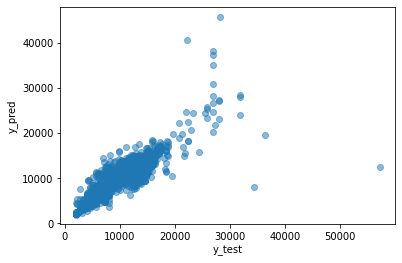

In [134]:
plt.scatter(y_test, y_pred, alpha = 0.5,)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [135]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1175.1176880088403
MSE: 4647442.563666556
RMSE: 2155.792792377448


In [136]:
metrics.r2_score(y_test, y_pred)

0.7844619968616456

## Hyperparameter Tuning
Choose following method for hyperparameter tuning
1. RandomizedSearchCV --> Fast
2. GridSearchCV
Assign hyperparameters in form of dictionary

Fit the model

Check best paramters and best score

In [143]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]


# Create Random Grid
random_grid = dict(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, 
                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

In [144]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_randomCV = RandomizedSearchCV(estimator = rf_reg, param_distributions = random_grid,scoring='neg_mean_squared_error', 
                               n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [145]:
rf_randomCV.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   8.6s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   9.4s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   9.3s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   9.3s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   9.2s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=  14.6s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   5.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.9s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.7s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   4.7s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 11.8min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [146]:
rf_randomCV.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [147]:
y_pred_1 = rf_randomCV.predict(X_test)

In [150]:
rf_randomCV.best_score_

-4582839.420697039

In [155]:
fig = pff.create_distplot(hist_data = [(y_test-y_pred).tolist(), (y_test-y_pred_1).tolist()], 
                          group_labels=['Price_old','Price_1'], bin_size=0, colors=['yellow','magenta'], show_hist=False, show_rug=False)
fig.update_layout(title_text='Price Distplot with Normal Distribution')
iplot(fig)

In [156]:
fig = go.Figure(data=go.Scatter(x=y_test,
                                y=y_pred_1,
                                mode='markers',
                                marker=dict(size=16,
                                            color=np.random.randn(10000), #set color equal to a variable
                                            colorscale='Viridis', # one of plotly colorscales
                                            showscale=True)
                                ))

fig.update_layout(title='y_test vs y_pred_1')
fig.show()

In [158]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_1))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))

MAE: 1221.4654984052715
MSE: 4710725.760864047
RMSE: 2170.42064145733


In [176]:

import pickle
# open a file, where you ant to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(rf_randomCV, file)

In [178]:
model = open('flight_rf.pkl','rb')
forest = pickle.load(model)

In [179]:
y_prediction = forest.predict(X_test)

In [180]:
metrics.r2_score(y_test, y_prediction)

0.7815270635581565

In [189]:
pip freeze


Note: you may need to restart the kernel to use updated packages.altair==4.1.0

argon2-cffi==20.1.0
astor==0.8.1
async-generator==1.10
attrs==20.2.0
backcall==0.2.0
base58==2.0.1
bleach==3.2.1
blinker==1.4
boto3==1.15.5
botocore==1.18.5
cachetools==4.1.1
certifi==2020.6.20
cffi==1.14.3
chardet==3.0.4
click==7.1.2
colorama==0.4.3
colorlover==0.3.0
cufflinks==0.17.3
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
entrypoints==0.3
enum-compat==0.0.3
flasgger==0.9.5
Flask==1.1.2
idna==2.10
importlib-metadata==1.7.0
ipykernel==5.3.4
ipython==7.18.1
ipython-genutils==0.2.0
ipywidgets==7.5.1
itsdangerous==1.1.0
jedi==0.17.2
Jinja2==2.11.2
jmespath==0.10.0
joblib==0.16.0
jsonschema==3.2.0
jupyter-client==6.1.7
jupyter-core==4.6.3
jupyterlab-pygments==0.1.1
kiwisolver==1.2.0
MarkupSafe==1.1.1
matplotlib==3.3.2
mistune==0.8.4
nbclient==0.5.0
nbconvert==6.0.5
nbformat==5.0.7
nest-asyncio==1.4.0
notebook==6.1.4
numpy==1.19.2
packaging==20.4
pandas==1.1.2
pandocfilters==1.4.2
parso==0.7.1
pathtoo